1. **Setup and Package Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm

sns.set_theme(style="whitegrid")

rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.1


In [2]:
ndraws = 2500
ntune  = 2500

In [3]:
group_colors = {
    'male': '#D7301F',    # Red for males
    'female': '#F4A40B',  # Yellow for females
    'atoke': '#654321'    # Brown for atokes
}

2. **Bring in Data and Normalize**

In [4]:
# Load and process data
fff_df = pd.read_csv('./../data/Pd_FFF.csv')
fff_df['Condition'] = fff_df['Group'] + "_" + fff_df['EyePosition']
fff_df['Recording'] = fff_df['id'] + "_" + fff_df['Group'] + "_" + fff_df['EyePosition']
fff_df.rename(columns={'AbsResponse': 'Response'}, inplace=True)
fff_df.dropna(subset=['Response'], inplace=True)
fff_df['Response'] = fff_df.groupby(['id', 'Condition'])['Response'].transform(lambda x: x / x.max())
fff_df['Group'] = fff_df['Group'].astype('category')
fff_df.tail()

,freq_Hz,ID,id,Observer,Group,EyePosition,Response,Condition,Recording
364,7.5,ag 06,f_f7,AG,female,anterior,0.103896,female_anterior,f_f7_female_anterior
365,8.5,ag 06,f_f7,AG,female,anterior,0.155844,female_anterior,f_f7_female_anterior
366,9.5,ag 06,f_f7,AG,female,anterior,0.038961,female_anterior,f_f7_female_anterior
367,10.5,ag 06,f_f7,AG,female,anterior,0.025974,female_anterior,f_f7_female_anterior
368,11.5,ag 06,f_f7,AG,female,anterior,0.038961,female_anterior,f_f7_female_anterior


3. **Liminal Value Calculation**

In [5]:
# Sort the DataFrame by 'freq_Hz'
fff_df_sorted = fff_df.sort_values('freq_Hz')

# Get the rows with the largest reponse below the threshold
liminal_df = fff_df_sorted[fff_df_sorted['Response'] < 0.1].groupby(['Recording']).agg(
    freq_Hz=('freq_Hz', 'first'), Response=('Response', 'first'))

# Reset index to make 'Recording' and 'freq_Hz' regular columns again
liminal_df = liminal_df.reset_index()

liminal_df = liminal_df.merge(fff_df_sorted[['Recording', 'freq_Hz', 'id', 'Condition', 'Observer', 'Group']], on=['Recording','freq_Hz'], how='left')
liminal_df = liminal_df.drop_duplicates(subset=['Recording', 'freq_Hz'])

Hz_mean = liminal_df['freq_Hz'].mean()
Hz_std  = liminal_df['freq_Hz'].std()
liminal_df['Hz_scaled'] = (liminal_df['freq_Hz'] - Hz_mean) / Hz_std

liminal_df

,Recording,freq_Hz,Response,id,Condition,Observer,Group,Hz_scaled
0,f_a10_atoke_anterior,5.5,0.080089,f_a10,atoke_anterior,AG,atoke,-0.445753
1,f_a11_atoke_anterior,5.5,0.069333,f_a11,atoke_anterior,JJB,atoke,-0.445753
2,f_a12_atoke_anterior,5.5,0.095590,f_a12,atoke_anterior,JJB,atoke,-0.445753
3,f_a13_atoke_anterior,8.5,0.063352,f_a13,atoke_anterior,JJB,atoke,0.734182
4,f_a14_atoke_anterior,7.5,0.058748,f_a14,atoke_anterior,JJB,atoke,0.340870
5,f_a1_atoke_posterior,7.5,0.065217,f_a1,atoke_posterior,JK,atoke,0.340870
6,f_a2_atoke_posterior,9.5,0.061798,f_a2,atoke_posterior,JK,atoke,1.127494
7,f_a4_atoke_posterior,8.5,0.075676,f_a4,atoke_posterior,danka,atoke,0.734182
8,f_a5_atoke_posterior,4.5,0.059996,f_a5,atoke_posterior,JJB,atoke,-0.839065
9,f_a6_atoke_posterior,5.5,0.075336,f_a6,atoke_posterior,JJB,atoke,-0.445753


In [6]:
# Sort the DataFrame by 'freq_Hz'
fff_df_sorted = fff_df.sort_values('freq_Hz')

# Get the rows with the largest reponse below the threshold
low_liminal_df = fff_df_sorted[fff_df_sorted['Response'] < 0.05].groupby(['Recording']).agg(
    freq_Hz=('freq_Hz', 'first'), Response=('Response', 'first'))

# Reset index to make 'Recording' and 'freq_Hz' regular columns again
low_liminal_df = low_liminal_df.reset_index()

low_liminal_df = low_liminal_df.merge(fff_df_sorted[['Recording', 'freq_Hz', 'id', 'Condition', 'Observer', 'Group']], on=['Recording','freq_Hz'], how='left')
low_liminal_df = low_liminal_df.drop_duplicates(subset=['Recording', 'freq_Hz'])

Hz_mean = low_liminal_df['freq_Hz'].mean()
Hz_std  = low_liminal_df['freq_Hz'].std()
low_liminal_df['Hz_scaled'] = (low_liminal_df['freq_Hz'] - Hz_mean) / Hz_std

liminal_not_in_low_liminal = liminal_df[~liminal_df['Recording'].isin(low_liminal_df['Recording'])]
liminal_not_in_low_liminal

,Recording,freq_Hz,Response,id,Condition,Observer,Group,Hz_scaled
6,f_a2_atoke_posterior,9.5,0.061798,f_a2,atoke_posterior,JK,atoke,1.127494
13,f_f1_female_posterior,10.5,0.086207,f_f1,female_posterior,AG,female,1.520806
15,f_f4_female_posterior,7.5,0.095041,f_f4,female_posterior,AG,female,0.340870
16,f_f5_female_anterior,14.5,0.074813,f_f5,female_anterior,AG,female,3.094053
17,f_f6_female_anterior,7.5,0.069307,f_f6,female_anterior,AG,female,0.340870


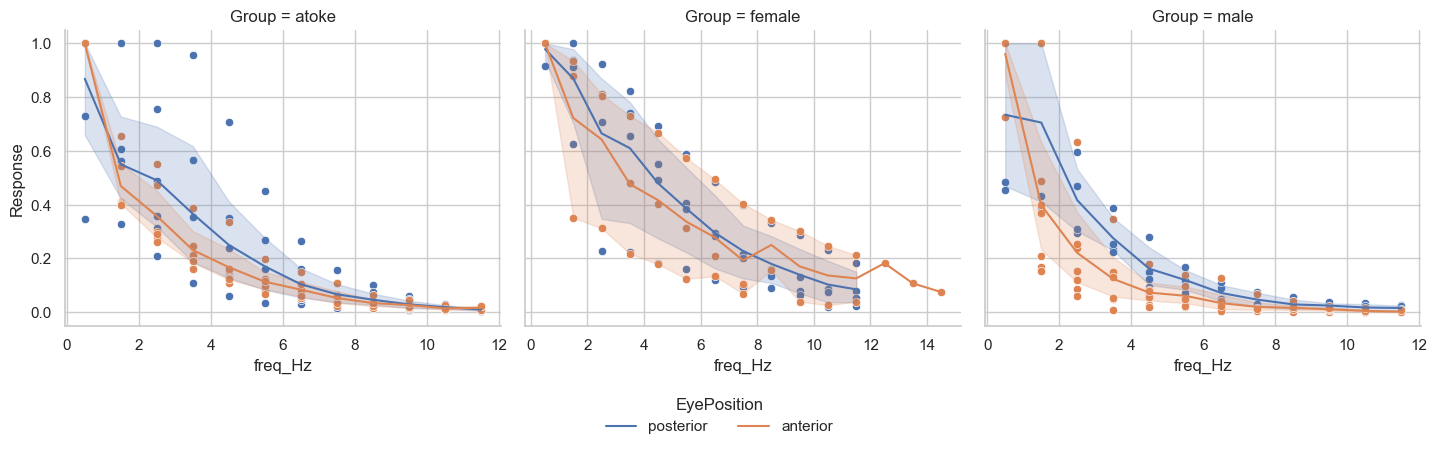

In [7]:
# Visaulize response with respect to flicker frequency 
g = sns.FacetGrid(fff_df, col="Group", hue="EyePosition", col_wrap=4, height=4, sharex=False, aspect=1.2)
g.map(sns.scatterplot, "freq_Hz", "Response")
g.map(sns.lineplot, "freq_Hz", "Response")
g.add_legend(bbox_to_anchor=(0.4, -0.06), ncol=2)
plt.show()

In [8]:
Groups = liminal_df['Group']
liminal_df['Recording'].nunique()

# Set up the categories with "atoke" as the reference category
Groups_cat = pd.Categorical(Groups, categories=['atoke', 'female', 'male'], ordered=True)

# Convert to numerical codes (dummy encoding with 'atoke' as the reference)
Groups_cat_codes = Groups_cat.codes
print(Groups_cat_codes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


In [9]:
# Define the response variable
Hz_scaled = liminal_df['Hz_scaled'].values

# Define the coordinates (dims) for the recordings
n_groups = len(set(Groups_cat_codes))

c:\Users\seano\miniforge3\envs\platynereis\Lib\site-packages\pymc\model\core.py:999: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(


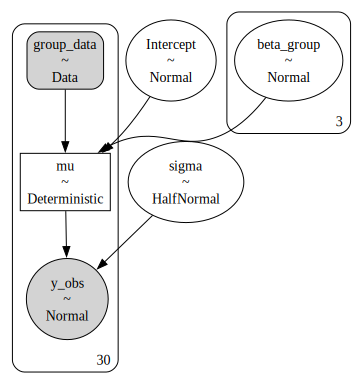

In [10]:
with pm.Model() as m1:
    # Define the coordinates for recordings and groups
    m1.add_coord("group", np.arange(n_groups), mutable=False)

    # Predictor data
    group_data = pm.Data("group_data", Groups_cat_codes)

    # Priors for intercept
    Intercept = pm.Normal('Intercept', mu=0, sigma=1)
    
    # Fixed effect for group: One coefficient for each group
    beta_group = pm.Normal("beta_group", mu=0, sigma=1, shape=n_groups)  # Coefficients for each group

    # Linear model with fixed group effects
    mu = pm.Deterministic("mu", Intercept + beta_group[group_data])

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Hz_scaled)

# Need graphviz for this part
pm.model_to_graphviz(m1)

Sampling: [Intercept, beta_group, sigma, y_obs]


<Axes: xlabel='y_obs'>

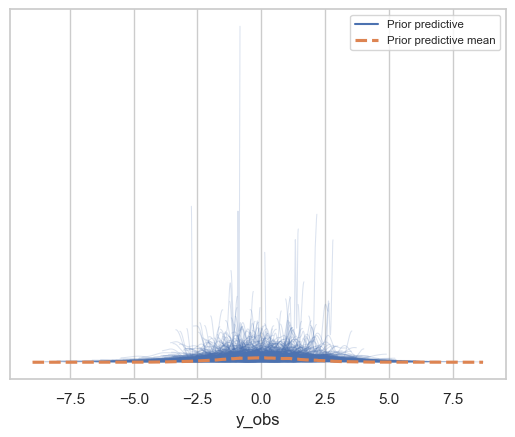

In [11]:
# PRIOR PREDICTIVE CHECK
with m1:
    idata = pm.sample_prior_predictive(samples=1000, random_seed=rng)

az.plot_ppc(idata, group="prior", kind="kde", data_pairs={"y_obs": "y_obs"})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_group, sigma]


Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 65 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'beta_group'}>,
        <Axes: title={'center': 'beta_group'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

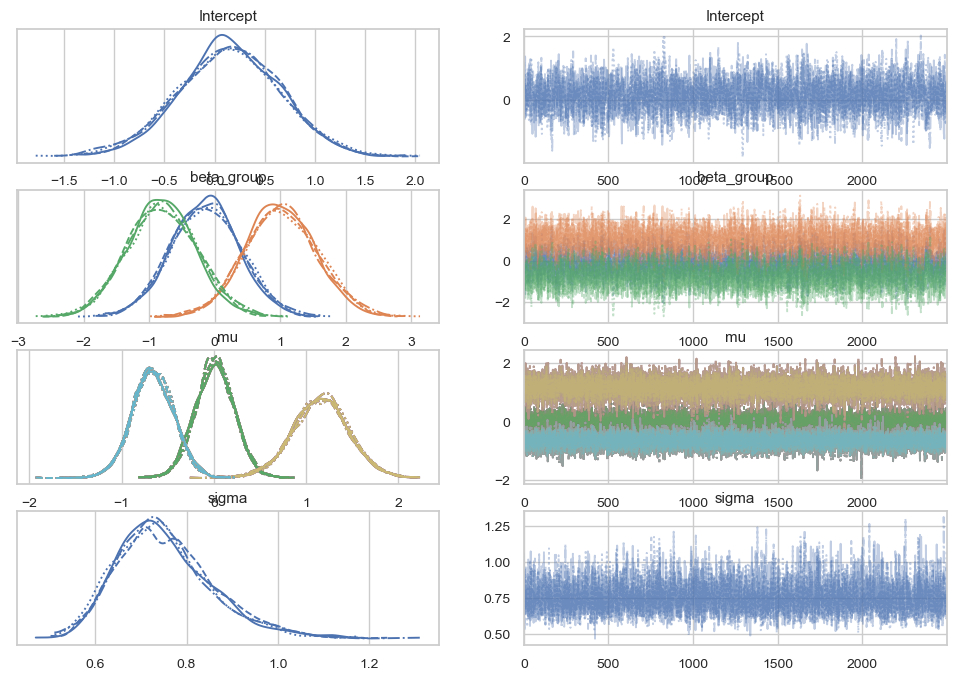

In [12]:
with m1:
    idata.extend(pm.sample(ndraws, tune=ntune, random_seed=rng))

az.plot_trace(idata)

In [13]:
with m1:
   idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng, predictions= True))
   idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng, predictions= False))

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

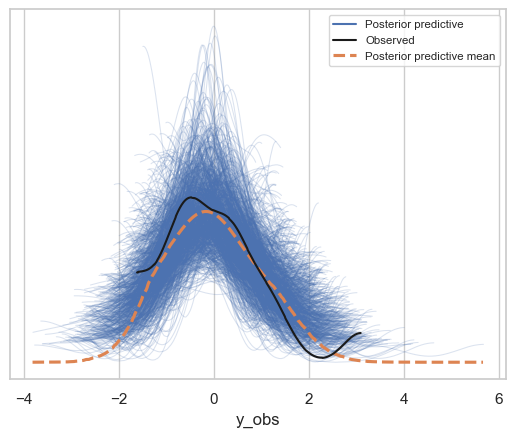

In [14]:
# POSTERIOR PREDICTIVE CHECK
az.plot_ppc(idata, group="posterior", kind="kde", data_pairs={"y_obs": "y_obs"}, num_pp_samples=1000)

In [15]:
# Convert 'y_obs' to a numpy array and reshape to 2 dimensions
y_obs_2d = idata.posterior_predictive['y_obs'].values.reshape(-1, len(Groups))

# Convert posterior predictive samples into a DataFrame
ppc_df = pd.DataFrame(y_obs_2d, columns=Groups)

# Take the mean of the predictions for each 'Group'
ppc_df_mean = ppc_df.groupby(level=0, axis=1).mean()

# Calculate summary statistics for each group
summary_stats = ppc_df_mean.describe()
summary_stats

C:\Users\seano\AppData\Local\Temp\ipykernel_7552\979913197.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ppc_df_mean = ppc_df.groupby(level=0, axis=1).mean()
C:\Users\seano\AppData\Local\Temp\ipykernel_7552\979913197.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc_df_mean = ppc_df.groupby(level=0, axis=1).mean()


Group,atoke,female,male
count,10000.000000,10000.000000,10000.000000
mean,0.013192,1.156188,-0.662823
std,0.299150,0.439793,0.322104
min,-1.256753,-0.684434,-2.013356
25%,-0.182564,0.872302,-0.872930
50%,0.015203,1.162498,-0.663338
75%,0.208911,1.448102,-0.450321
max,1.215568,2.947689,0.757046


In [16]:
# Convert 'y_obs' to a numpy array and reshape to 2 dimensions
y_obs_2d = idata.posterior_predictive['y_obs'].values.reshape(-1, len(Groups))

# Convert posterior predictive samples into a DataFrame
ppc_df = pd.DataFrame(y_obs_2d, columns=Groups)

C:\Users\seano\AppData\Local\Temp\ipykernel_7552\3776731484.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ppc_df_mean = ppc_df.groupby(level=0, axis=1).mean()
C:\Users\seano\AppData\Local\Temp\ipykernel_7552\3776731484.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc_df_mean = ppc_df.groupby(level=0, axis=1).mean()
C:\Users\seano\AppData\Local\Temp\ipykernel_7552\3776731484.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=ppc_df_melt, x='Group', y='Hz scaled',  palette=group_colors)


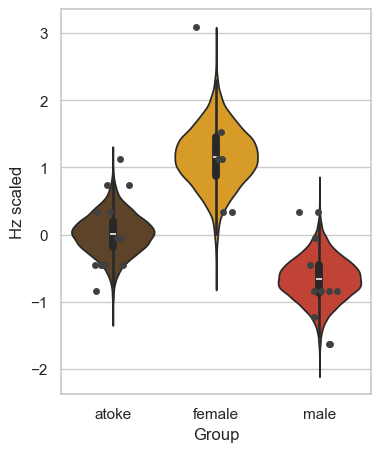

In [17]:
# Take the mean of the predictions for each 'Group'
ppc_df_mean = ppc_df.groupby(level=0, axis=1).mean()

# Melt the DataFrame to long format for plotting
ppc_df_melt = ppc_df_mean.melt(var_name='Group', value_name='Hz scaled')
ppc_df_melt['Frequency (Hz)'] = (ppc_df_melt['Hz scaled'] * Hz_std) + Hz_mean

# Plot boxplots
plt.figure(figsize=(4, 5))
sns.violinplot(data=ppc_df_melt, x='Group', y='Hz scaled',  palette=group_colors)
sns.stripplot(data=liminal_df,   x="Group", y="Hz_scaled", color="0.25", jitter=0.2)
plt.show()

In [18]:
# Assuming df is your DataFrame with 'Group' and 'Hz_scaled' columns
def compute_credible_interval(group):
    lower = group["Hz scaled"].quantile(0.025)
    upper = group["Hz scaled"].quantile(0.975)
    return pd.Series({'lower_bound': lower, 'upper_bound': upper})

# Group by 'Group' and compute the 95% credible interval for 'Hz_scaled'
credible_intervals = ppc_df_melt.groupby('Group').apply(compute_credible_interval).reset_index()

C:\Users\seano\AppData\Local\Temp\ipykernel_7552\3163678467.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credible_intervals = ppc_df_melt.groupby('Group').apply(compute_credible_interval).reset_index()
C:\Users\seano\AppData\Local\Temp\ipykernel_7552\3163678467.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  credible_intervals = ppc_df_melt.groupby('Group').apply(compute_credible_interval).reset_index()


C:\Users\seano\AppData\Local\Temp\ipykernel_7552\1489372995.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credible_intervals = ppc_df_melt.groupby('Group')['Frequency (Hz)'].quantile([0.025, 0.975]).unstack()


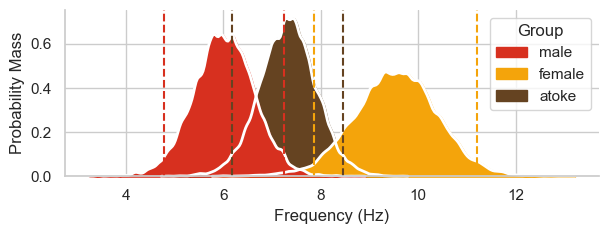

In [19]:
import matplotlib.patches as mpatches

# First, compute the 95% credible intervals for 'Frequency (Hz)'
credible_intervals = ppc_df_melt.groupby('Group')['Frequency (Hz)'].quantile([0.025, 0.975]).unstack()

# Set up the FacetGrid with the custom palette
g = sns.FacetGrid(ppc_df_melt, hue="Group", palette=group_colors, aspect=2.5, height=2.5)

# Map the KDE plot to the grid
g.map(sns.kdeplot, "Frequency (Hz)", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)

# Draw the white line over the density plot to highlight boundaries
g.map(sns.kdeplot, "Frequency (Hz)", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# Add vertical lines for the 95% credible intervals using the group color palette
for group, ci in credible_intervals.iterrows():
    plt.axvline(x=ci[0.025], color=group_colors[group], linestyle='--')
    plt.axvline(x=ci[0.975], color=group_colors[group], linestyle='--')

plt.ylabel('Probability Mass')

# Add legend and show plot
# Create custom legend handles to map each group to the correct color
handles = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]

# Add custom legend
plt.legend(handles=handles, title="Group", loc="best")
plt.show()

In [20]:
# # Plot boxplots
# plt.figure(figsize=(4, 5))
# sns.violinplot(data=ppc_df_melt, x='Group', y='Frequency (Hz)', palette=group_colors)
# sns.stripplot(data=liminal_df,   x="Group", y="freq_Hz", color="0.25", jitter=0.2,
#               dodge=True, size=6)

# plt.show()

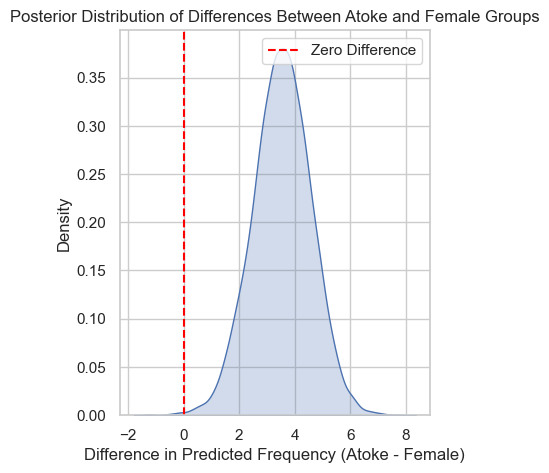

In [21]:
# Ensure 'Group' column has 'atoke' and 'female' entries
atoke_predictions = ppc_df_melt[ppc_df_melt['Group'] == 'atoke']['Frequency (Hz)'].values
female_predictions = ppc_df_melt[ppc_df_melt['Group'] == 'female']['Frequency (Hz)'].values
male_predictions = ppc_df_melt[ppc_df_melt['Group'] == 'male']['Frequency (Hz)'].values

# Calculate the difference between 'Atoke' and 'Female' predictions
diff_female_atoke = female_predictions - atoke_predictions
diff_male_atoke = male_predictions - atoke_predictions
diff_female_male = female_predictions - male_predictions

# Create a DataFrame for the contrast
contrast_df = pd.DataFrame({
    'Difference_Female_Atoke': diff_female_atoke,
    'Difference_Male_Atoke': diff_male_atoke,
    'Difference_Female_Male': diff_female_male,
})

plt.figure(figsize=(4, 5))
sns.kdeplot(contrast_df['Difference_Female_Male'], fill=True)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference in Predicted Frequency (Atoke - Female)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Differences Between Atoke and Female Groups')
plt.legend()
plt.show()

In [22]:
# Calculate the proportion of the probability mass in the contrasts
contrast_proportions = {
    'Contrast': ['Female - Atoke', 'Male - Atoke', 'Female - Male'],
    'P(Diff < 0)': [
        np.mean(diff_female_atoke < 0),
        np.mean(diff_male_atoke < 0),
        np.mean(diff_female_male < 0)
    ],
    'P(Diff > 0)': [
        np.mean(diff_female_atoke > 0),
        np.mean(diff_male_atoke > 0),
        np.mean(diff_female_male > 0)
    ],
    'P(Diff ≈ 0)': [
        np.mean(np.abs(diff_female_atoke) < 0.01),  # Proportion near zero (threshold of 0.01)
        np.mean(np.abs(diff_male_atoke) < 0.01),
        np.mean(np.abs(diff_female_male) < 0.01)
    ]
}

# Create a DataFrame for the contrast proportions
contrast_proportions_df = pd.DataFrame(contrast_proportions)

# Display the table of proportions
contrast_proportions_df

,Contrast,P(Diff < 0),P(Diff > 0),P(Diff ≈ 0)
0,Female - Atoke,0.0188,0.9812,0.0007
1,Male - Atoke,0.9383,0.0617,0.0038
2,Female - Male,0.0017,0.9983,0.0000


C:\Users\seano\AppData\Local\Temp\ipykernel_7552\3832378324.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credible_intervals = ppc_df_melt.groupby('Group')['Frequency (Hz)'].quantile([0.025, 0.975]).unstack()


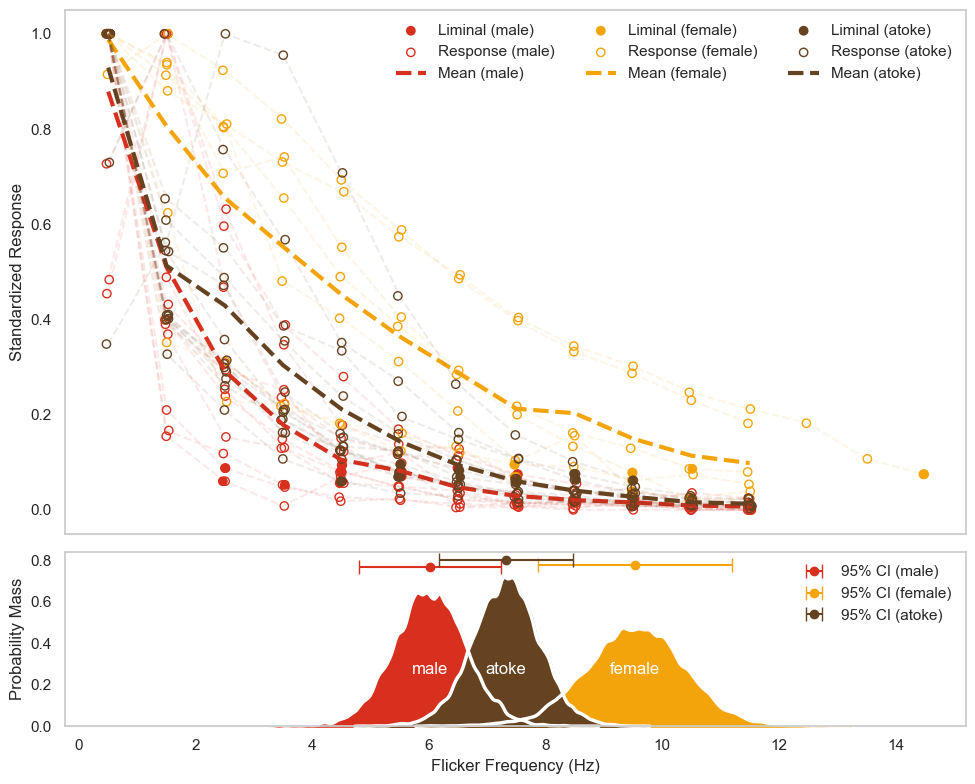

In [23]:
# Define jitter amount for scatter plot
jitter_amount = 0.04

# Create a figure and two subplots (scatter plot on top, density plot below)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Scatter plot on the first subplot (ax1)
for group in group_colors:
    mask = fff_df['Group'] == group
    lim_mask = liminal_df['Group'] == group
    
    # Plot faint lines for each recording within the group
    for recording in fff_df[mask]['Recording'].unique():
        recording_mask = (fff_df['Recording'] == recording) & mask
        sorted_data = fff_df[recording_mask].sort_values('freq_Hz')
        ax1.plot(sorted_data['freq_Hz'], sorted_data['Response'], 
                 color=group_colors[group], alpha=0.1, linestyle="--")
    
    # Plot filled scatter points for liminal data
    ax1.scatter(liminal_df['freq_Hz'][lim_mask] + 
                np.random.uniform(-jitter_amount, jitter_amount, size=liminal_df['freq_Hz'][lim_mask].shape),
                liminal_df['Response'][lim_mask], label=f'Liminal ({group})',
                s=50,
                color=group_colors[group], edgecolors='none', facecolors=group_colors[group])
    
    # Plot scatter points for observed data
    ax1.scatter(fff_df['freq_Hz'][mask] + 
                np.random.uniform(-jitter_amount, jitter_amount, size=fff_df['freq_Hz'][mask].shape),
                fff_df['Response'][mask], label=f'Response ({group})',
                color=group_colors[group], facecolors='none', edgecolors=group_colors[group])
    
    # Calculate the mean response for each unique frequency in the group
    group_data = fff_df[mask]
    group_data = group_data[group_data['freq_Hz'] < 12]
    freq_mean = group_data.groupby('freq_Hz')['Response'].mean()
    
    sorted_freq = freq_mean.index
    sorted_mean = freq_mean.values
    
    # Plot mean line
    ax1.plot(sorted_freq, sorted_mean, color=group_colors[group], linestyle='--', linewidth=3, label=f'Mean ({group})')

# Final formatting for the scatter plot (ax1)
ax1.set_ylabel('Standardized Response')
ax1.legend(frameon=False, ncol=3)
ax1.grid(False)

# KDE plot on the second subplot (ax2)
credible_intervals = ppc_df_melt.groupby('Group')['Frequency (Hz)'].quantile([0.025, 0.975]).unstack()

# KDE plot for each group
for group in group_colors:
    sns.kdeplot(data=ppc_df_melt[ppc_df_melt['Group'] == group], x="Frequency (Hz)", ax=ax2,
                bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, color=group_colors[group])
    
    # White line on top of the filled KDE plot
    sns.kdeplot(data=ppc_df_melt[ppc_df_melt['Group'] == group], x="Frequency (Hz)", ax=ax2,
                bw_adjust=0.5, clip_on=False, color='white', lw=2.5)

    # Get 95% credible interval for this group
    ci = credible_intervals.loc[group]
    mean_freq = ppc_df_melt[ppc_df_melt['Group'] == group]['Frequency (Hz)'].mean()
    
    # Plot horizontal error bars marking the 95% credible interval
    ax2.errorbar(x=mean_freq, y=0.8 + np.random.uniform(-jitter_amount, jitter_amount, size=1),
                 xerr=[[mean_freq - ci[0.025]], [ci[0.975] - mean_freq]],
                 fmt='o', color=group_colors[group], capsize=5, label=f'95% CI ({group})')
    
    # Add the group name annotation
    ax2.text(mean_freq, 0.275, group, color='white', fontsize=12, ha='center', va='center')


# Final formatting for the KDE plot (ax2)
ax2.set_xlabel('Flicker Frequency (Hz)')
ax2.set_ylabel('Probability Mass')

# Custom legend for the KDE plot
handles = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax2.legend(handles=handles, title="Group", loc="best")
ax2.grid(False)
ax2.legend(frameon=False)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()